In [373]:
import h5py
import matplotlib
from matplotlib import pyplot as plt, cm
# from habitat.utils.visualizations import maps
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import cv2
import ast
import random

In [323]:
def plot_colortable(colors, title, sort_colors=False, emptycols=0):
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left")

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)
        
    plt.show()

In [4]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [5]:
def draw_top_down_map(mapp,fogg,cordd, heading, output_size):
    top_down_map = maps.colorize_topdown_map(
        mapp, fogg
    )
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = cordd
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

# Load HDF5 File

In [127]:
file = h5py.File('/media/cds-s/data/Datasets/Habitat/HPointLoc/1LXtFkjw3qL_point0/1LXtFkjw3qL_point0.hdf5', 'r')

In [176]:
rgb = file['rgb']
depth = file['depth']
semantic = file['semantic']
# objectgoal = file['objectgoal']
compass = file['compass']
gps = file['gps']
heading = file['heading']
top_down_map = file['top_down_map']
fog_of_war_mask = file['fog_of_war_mask']
agent_map_coord = file['agent_map_coord']
agent_angle = file['agent_angle']
mapping = np.array(file['mapping'])
index_to_title_map = ast.literal_eval(str(np.array(file['index_to_title_map']))[2:-1])

In [152]:
# Подсчет количества категорий семантик
from tqdm import tqdm
semantic_titles = {}
# index_to_title = {}
root_dir = '/media/cds-s/data/Datasets/Habitat/HPointLoc/'
for map_name in tqdm(os.listdir(root_dir)):
    if map_name != '1LXtFkjw3qL_point0':
        continue
    if map_name.find('.') != -1:
        continue
    for hdf5_filename in os.listdir(os.path.join(root_dir, map_name)):
        if hdf5_filename.find('.hdf5') == -1:
            continue
        hdf5_file = h5py.File(os.path.join(root_dir, map_name, hdf5_filename))
        index_to_title_map = ast.literal_eval(str(np.array(hdf5_file['index_to_title_map']))[2:-1])
        mapping = np.array(hdf5_file['mapping'])
#         index_to_title.update(index_to_title_map)
        semantic_base = hdf5_file['semantic_base']
        semantic_base = np.unique(semantic_base)
        semantic = hdf5_file['semantic']
        semantic = np.unique(semantic)
#         print(index_to_title_map)
        for semantic_id in semantic_base:
            semantic_title = index_to_title[mapping[semantic_id]]
            if not(semantic_title in semantic_titles.keys()): 
                semantic_titles[semantic_title] = 1
            else:
                semantic_titles[semantic_title] += 1
        for semantic_id in semantic:
            if not(semantic_title in semantic_titles.keys()): 
                semantic_titles[semantic_title] = 1
            else:
                semantic_titles[semantic_title] += 1

100%|██████████| 49/49 [00:00<00:00, 50.07it/s]


In [166]:
len(index_to_title)

42

In [153]:
num = 0
for key in sorted(semantic_titles.keys()):
    num += semantic_titles[key]
    print ("{} : {}".format(key, semantic_titles[key]))
# print(num - 1420)

bathtub : 11
bed : 28
board_panel : 3
cabinet : 26
ceiling : 249
chair : 48
chest_of_drawers : 8
curtain : 11
cushion : 15
door : 1174
floor : 290
furniture : 8
gym_equipment : 10
lighting : 184
mirror : 16
misc : 180
objects : 67
picture : 115
plant : 2
seating : 6
shelving : 18
shower : 4
sink : 6
sofa : 6
stairs : 15
table : 15
toilet : 3
towel : 17
tv_monitor : 10
void : 10
wall : 601
window : 110


In [154]:
num

3266

In [144]:
sorted(set_of_semantic_titles)

['',
 'appliances',
 'bathtub',
 'beam',
 'bed',
 'blinds',
 'board_panel',
 'cabinet',
 'ceiling',
 'chair',
 'chest_of_drawers',
 'clothes',
 'column',
 'counter',
 'curtain',
 'cushion',
 'door',
 'fireplace',
 'floor',
 'furniture',
 'gym_equipment',
 'lighting',
 'mirror',
 'misc',
 'objects',
 'picture',
 'plant',
 'railing',
 'seating',
 'shelving',
 'shower',
 'sink',
 'sofa',
 'stairs',
 'stool',
 'table',
 'toilet',
 'towel',
 'tv_monitor',
 'void',
 'wall',
 'window']

In [99]:
# Подсчет всех ключевых поз - облаков

set_of_points = set()
from pathlib import Path

root_dir = '/media/cds-s/data/Datasets/Habitat/extracted_HPointLoc/1LXtFkjw3qL_point0/'
all_filenames = list(Path(root_dir).glob("**/*.png"))
# print(len(all_filenames))
for filename in all_filenames:
    filename = filename.relative_to(Path(root_dir))
    filename = str(filename)
    filename = filename.split("/")[-1]
    set_of_points.add("_".join([filename.split('_')[-4], filename.split('_')[-3]]))
print(set_of_points)

{'1LXtFkjw3qL_point1', '1LXtFkjw3qL_point7', '1LXtFkjw3qL_point11', '1LXtFkjw3qL_point20', '1LXtFkjw3qL_point3', '1LXtFkjw3qL_point17', '1LXtFkjw3qL_point14', '1LXtFkjw3qL_point6', '1LXtFkjw3qL_point21', '1LXtFkjw3qL_point13', '1LXtFkjw3qL_point4', '1LXtFkjw3qL_point18', '1LXtFkjw3qL_point5', '1LXtFkjw3qL_point15', '1LXtFkjw3qL_point22', '1LXtFkjw3qL_point19', '1LXtFkjw3qL_point2', '1LXtFkjw3qL_point10', '1LXtFkjw3qL_point8', '1LXtFkjw3qL_point16', '1LXtFkjw3qL_point9', '1LXtFkjw3qL_point12', '1LXtFkjw3qL_point0'}


# Examples of what inside

In [10]:
print('Full trajectory has {} steps'.format(len(rgb)))

Full trajectory has 36 steps


In [130]:
# Pick frame number 133 to all further examples
index = 20

In [50]:
# print('Goal object is {} - {}'.format(objectgoal[index],index_to_title_map[objectgoal[index][0]]))
# print('GPS position {}'.format(gps[index]))
# print('Compas position {}'.format(compass[index]))

In [51]:
mapp = draw_top_down_map(top_down_map[index],fog_of_war_mask[index],agent_map_coord[index],heading[index][0],rgb[index].shape[0])
plt.imshow(mapp)

NameError: name 'maps' is not defined

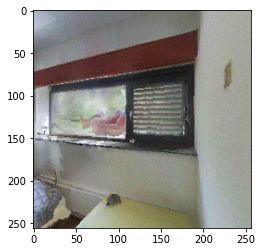

In [46]:
plt.imshow(rgb[index])

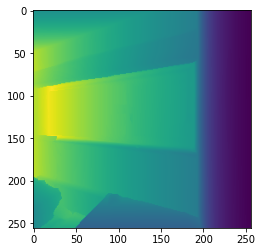

In [47]:
plt.imshow(depth[index][:,:,0])

In [114]:
np.unique(semantic_base[1])

array([  0, 731, 735, 737], dtype=uint32)

Number of labels: 802


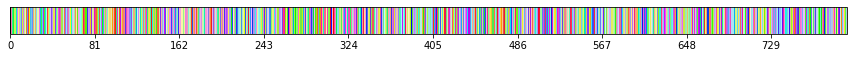

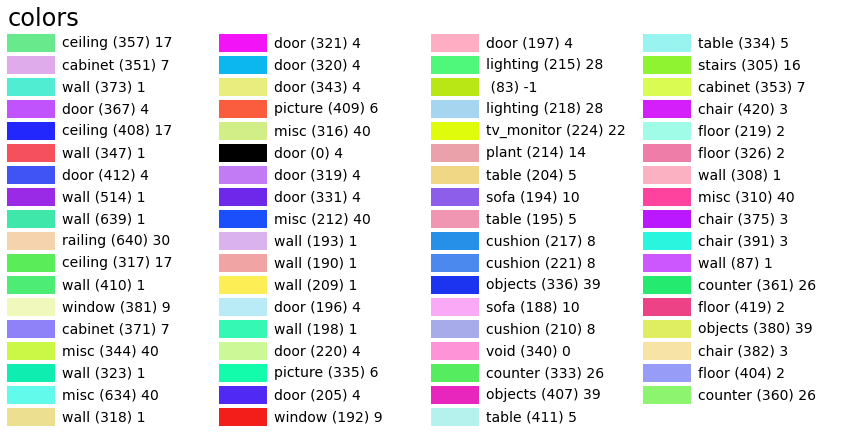

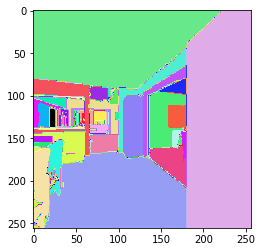

In [316]:
# Semantic sensor output with annotation, number in brackets is item number
# number after brackets is number that corresponds to each object 
# (different chairs has different number in brackets but same number after brackets)
semantic_image = semantic[index]

elements_in_image = []
    
for string in semantic_image:
    for el in string:
        if not(el in elements_in_image):
            elements_in_image.append(el)
            
colors = list(mcolors.CSS4_COLORS.values())
new_colors = colors
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))            
ccmap = matplotlib.cm.get_cmap('jet')   
new_cmap = cmap
new_cmap = rand_cmap(len(mapping), type='bright', first_color_black=True, last_color_black=False, verbose=True)
colorss = {}

for i,entry in enumerate(elements_in_image):
    label = index_to_title_map[mapping[entry]] + ' (' + str(entry)+ ') ' + str(mapping[entry])
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=len(mapping))
    
    colorss[label] = new_cmap(norm(entry))
        
plot_colortable(colorss, 'colors')
    
plt.imshow(semantic_image, cmap=new_cmap, vmin=-1, vmax=len(mapping)) 

# Сохранение изображений 10х6х3 (RGB, depth, semantic)

In [329]:
root_dir = "/media/cds-s/data/Datasets/Habitat/HPointLoc/"
outputdir_for_picture = "/media/cds-s/data/Datasets/Habitat/Pictures_for_paper/10_maps_with_6_points_with_3_images/"
list_of_maps = os.listdir(root_dir)
list_of_maps.remove("1LXtFkjw3qL_point0")
random_maps = random.sample(list_of_maps, 9)
list_of_chosen_maps = random_maps
list_of_chosen_maps.append("1LXtFkjw3qL_point0")

In [350]:
ccmap(33)

(0.24117647058823533, 0.3954512068705425, 0.9794097676013659, 1.0)

In [351]:
ccmap(2)

(0.4843137254901961, 0.02463744919538197, 0.9999241101148306, 1.0)

In [356]:
file.keys()

<KeysViewHDF5 ['agent_angle', 'agent_angle_base', 'agent_map_coord', 'agent_map_coord_base', 'compass', 'compass_base', 'depth', 'depth_base', 'fog_of_war_mask', 'fog_of_war_mask_base', 'gps', 'gps_base', 'heading', 'heading_base', 'index_to_title_map', 'mapping', 'quat', 'quat_base', 'rgb', 'rgb_base', 'semantic', 'semantic_base', 'top_down_map', 'top_down_map_base']>

In [398]:
ccmap = matplotlib.cm.get_cmap('rainbow')
ccmap.set_under('black')
norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=len(index_to_title))

for map_name in tqdm(list_of_chosen_maps): # По каждой из выбранных десяти карт
    list_of_hdf5_filename = list(Path(os.path.join(root_dir, map_name)).glob("**/*.hdf5"))
    random_hdf5_filename = str(random.sample(list_of_hdf5_filename, 1)[0]) # Выбираем случайную точку (point)
    hdf5_short_name = random_hdf5_filename.split('/')[-1]
    hdf5_short_name = hdf5_short_name.rstrip('.hdf5')
    
    file = h5py.File(random_hdf5_filename, 'r')
    
    rgb = file['rgb']
    depth = file['depth']
    semantic = file['semantic']
    # objectgoal = file['objectgoal']
    compass = file['compass']
    gps = file['gps']
    
    rgb_base = file['rgb_base']
    depth_base = file['depth_base']
    semantic_base = file['semantic_base']
    # objectgoal = file['objectgoal']
    compass_base = file['compass_base']
    gps_base = file['gps_base']
    
    heading = file['heading']
    top_down_map = file['top_down_map']
    fog_of_war_mask = file['fog_of_war_mask']
    agent_map_coord = file['agent_map_coord']
    agent_angle = file['agent_angle']
    mapping = np.array(file['mapping'])
    index_to_title_map = ast.literal_eval(str(np.array(file['index_to_title_map']))[2:-1])
    
    for index in range(6): # Проходим по всем изображениями database этой точки
    
        filename_fig = hdf5_short_name + "_" + str(index).zfill(4) + ".png"

        semantic_image = semantic_base[index]

        colorss = {}

#         for instance_index in np.unique(semantic_image):
#             title = index_to_title_map[mapping[instance_index]]
#             colorss[title] = ccmap(norm(title_to_index[title]))

        for i in range(semantic_image.shape[0]):
            for j in range(semantic_image.shape[1]):
                semantic_title = index_to_title_map[mapping[semantic_image[i, j]]]
                semantic_index = title_to_index[semantic_title]
                if semantic_title == "" or semantic_title == "void":
                    semantic_index = -1
                semantic_image[i, j] = semantic_index
        #         colorss[semantic_title] = ccmap(norm(semantic_index))

#         plot_colortable(colorss, 'colors')
        # plt.imshow(semantic_image, cmap=ccmap, vmin=-1, vmax=len(index_to_title))

        fig=plt.figure(figsize=(15, 5))
        columns = 3
        rows = 1
        img = []
        w=256
        h=256

        img.append(rgb_base[index])
        img.append(depth_base[index][:,:,0])
        img.append(semantic_image)
        # plt.axis('off')
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i == 1:  
                plt.axis('off')
                plt.imshow(img[i-1])
            if i == 2:  
                plt.axis('off')
                plt.imshow(img[i-1])
            if i == 3:
                plt.axis('off')
                plt.imshow(img[i-1], cmap=ccmap, vmin=-1, vmax=len(index_to_title))
        fig.tight_layout(pad=1.0)
        plt.savefig(os.path.join(outputdir_for_picture, filename_fig))
        plt.close(fig)

/home/cds-s/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rainbow").copy()
  
100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


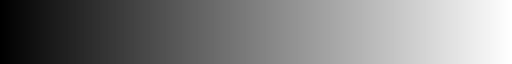

In [374]:
cmap = cm.get_cmap('gray')
cmap.set_under('red')
cmap

/home/cds-s/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  """Entry point for launching an IPython kernel.


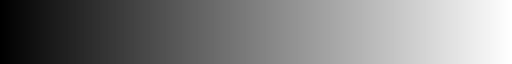

In [375]:
cmap.set_under('red')
cmap

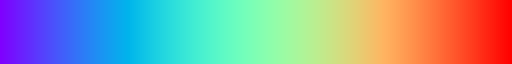

In [379]:
ccmap

In [396]:
title_to_index["void"] = -1
title_to_index[""] = -1

In [387]:
title_to_index

{'ceiling': 17,
 'column': 24,
 'wall': 1,
 'chair': 3,
 'misc': 40,
 'floor': 33,
 'sofa': 10,
 'bed': 11,
 'tv_monitor': 22,
 'door': 4,
 'objects': 39,
 '': 1,
 'shower': 23,
 'stairs': 16,
 'picture': 6,
 'board_panel': 35,
 'lighting': 28,
 'window': 9,
 'cushion': 8,
 'cabinet': 7,
 'table': 5,
 'curtain': 12,
 'void': 1,
 'railing': 30,
 'mirror': 21,
 'gym_equipment': 2,
 'chest_of_drawers': 13,
 'stool': 19,
 'plant': 14,
 'appliances': 37,
 'counter': 26,
 'seating': 34,
 'sink': 15,
 'bathtub': 25,
 'toilet': 18,
 'shelving': 31,
 'towel': 20,
 'beam': 29,
 'fireplace': 27,
 'furniture': 36,
 'clothes': 38,
 'blinds': 32}

In [388]:
# title_to_index["gym_equipment"] = 2
# title_to_index["floor"] = 33

In [400]:
title_to_index

{'ceiling': 17,
 'column': 24,
 'wall': 1,
 'chair': 3,
 'misc': 40,
 'floor': 33,
 'sofa': 10,
 'bed': 11,
 'tv_monitor': 22,
 'door': 4,
 'objects': 39,
 '': -1,
 'shower': 23,
 'stairs': 16,
 'picture': 6,
 'board_panel': 35,
 'lighting': 28,
 'window': 9,
 'cushion': 8,
 'cabinet': 7,
 'table': 5,
 'curtain': 12,
 'void': -1,
 'railing': 30,
 'mirror': 21,
 'gym_equipment': 2,
 'chest_of_drawers': 13,
 'stool': 19,
 'plant': 14,
 'appliances': 37,
 'counter': 26,
 'seating': 34,
 'sink': 15,
 'bathtub': 25,
 'toilet': 18,
 'shelving': 31,
 'towel': 20,
 'beam': 29,
 'fireplace': 27,
 'furniture': 36,
 'clothes': 38,
 'blinds': 32}

In [399]:
ccmap(17)

(0.3666666666666667, 0.20791169081775931, 0.9945218953682733, 1.0)

In [401]:
ccmap(-1)

(0.0, 0.0, 0.0, 1.0)

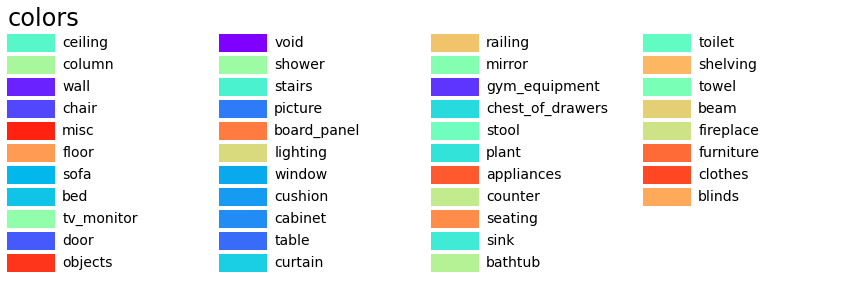

In [397]:
index_to_title = {v: k for k, v in title_to_index.items()}

colorss = {}

for semantic_index in index_to_title.keys():
    title = index_to_title[semantic_index]
    colorss[title] = ccmap(norm(semantic_index))
    
plot_colortable(colorss, 'colors')

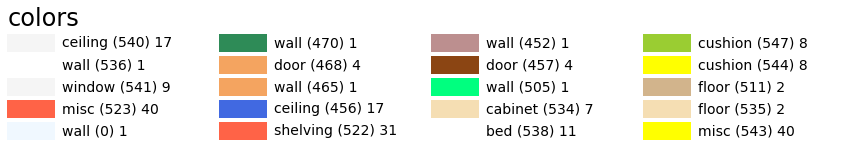

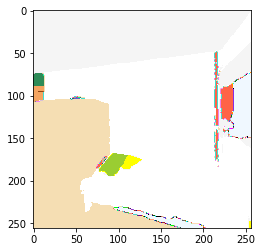

In [133]:
# Semantic sensor output with annotation, number in brackets is item number
# number after brackets is number that corresponds to each object 
# (different chairs has different number in brackets but same number after brackets)
semantic_image = semantic[index]

elements_in_image = []
    
for string in semantic_image:
    for el in string:
        if not(el in elements_in_image):
            elements_in_image.append(el)
            
colors = list(mcolors.CSS4_COLORS.values())
new_colors = colors
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))            
ccmap = matplotlib.cm.get_cmap('jet')   
# new_cmap = rand_cmap(len(mapping), type='bright', first_color_black=True, last_color_black=False, verbose=True)
new_cmap = cmap
colorss = {}

for i,entry in enumerate(elements_in_image):
    label = index_to_title_map[mapping[entry]] + ' (' + str(entry)+ ') ' + str(mapping[entry])
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=len(mapping))
    
    colorss[label] = new_cmap(norm(entry))
        
plot_colortable(colorss, 'colors')
    
plt.imshow(semantic_image, cmap=new_cmap, vmin=-1, vmax=len(mapping))
plt.show()    